# CUCAI Graphs

## Helper Functions

In [1]:
import torch 
import tensorflow as tf
import torch.nn as nn
import numpy as np
import gym
import matplotlib.pyplot as plt
import ncps 
from ncps.torch import LTC
from ncps.torch import CfC
from ncps.wirings import AutoNCP
import pytorch_lightning as pl
import torch.utils.data as data
from wm_ppo import PPO

2025-02-24 19:52:09.444337: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 19:52:09.851387: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-24 19:52:11.664691: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [3]:
angular_velocity = 2
max_angular_velocity_magnitude = 8
def get_rnd_env_samples(env, num_rollouts, scale_vel = True):
    
    t_obs = []
    t_a = []
    t_n_obs = []
    for _ in range(num_rollouts):
        
        observation, info = env.reset()
        
        terminated = False
        truncated = False
    
        c_obs = []
        c_a = []
        c_n_obs = []
        
        while not (terminated or truncated):
            # Get the action from the trained PPO agent
            #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
            obs = observation
            v_obs = torch.FloatTensor(observation)
    
            action = env.action_space.sample()
        
            # Take a step in the environment
            observation, reward, terminated, truncated, info = env.step(action)
            
            c_obs.append(obs)
            c_a.append(action)
            c_n_obs.append(observation)
       
        # Once the episode is done, close the environment
        #env.close()
    
        t_obs.append(np.vstack(c_obs))
        t_a.append(np.vstack(c_a))
        t_n_obs.append(np.vstack(c_n_obs))
    
    env.close()
    
    t_obs = np.stack(t_obs)
    t_a = np.stack(t_a)
    t_n_obs = np.stack(t_n_obs)
    
    #t_obs.shape
    #t_a.shape
    if scale_vel == True:
        t_obs[:, :, angular_velocity] = t_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
        t_n_obs[:, :, angular_velocity] = t_n_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
    
    inputs = np.concatenate((t_obs, t_a), axis=2)

    return inputs, t_n_obs

In [4]:
def residual_plot(outputs: np.array, residuals:np.array, title:str) -> None:
    fig,ax = plt.subplots(3,1,figsize=(14,8))
    ax[0].set_title(title)
    ax[0].scatter(outputs[:,0],residuals[:,0],label='x error',alpha=0.2)
    ax[1].scatter(outputs[:,1],residuals[:,1],label='y error',alpha=0.2)
    ax[2].scatter(outputs[:,2]*max_angular_velocity_magnitude,residuals[:,2],label='velocity error',alpha=0.2)
    for i in range(3):
      ax[i].legend()
      ax[i].grid(alpha=0.5)
      ax[i].axhline(0,ls='--',c='k')
      ax[i].set_xlabel('true value')
      ax[i].set_ylabel('prediction error')
    plt.tight_layout()

## Train Models

### DNN (Residual Net)

In [200]:
num_rollouts = 100 # 100 * 200 = 20,000 training samples. should be fine..? 
env = gym.make("Pendulum-v1")
inputs, outputs = get_rnd_env_samples(env, num_rollouts)

In [201]:
def build_world_model():
    xin_s = tf.keras.layers.Input((3,))
    xin_noise = tf.keras.layers.Input((3,))

    xs = tf.keras.layers.Add()([xin_s, xin_noise])
    xs = tf.keras.layers.Dense(32, activation='swish')(xs)
    xs = tf.keras.layers.Dense(32, activation='swish')(xs)

    xin_a = tf.keras.layers.Input((1,))
    xa = tf.keras.layers.Dense(32, activation='swish')(xin_a)

    xs = tf.keras.layers.Concatenate()([xs,xa])
    xs = tf.keras.layers.Dense(32, activation='swish')(xs)
    xs = tf.keras.layers.Dense(3)(xs)
    return tf.keras.models.Model([xin_s, xin_noise, xin_a], xs)

build_world_model().summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_25      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 3)         │          0 │ input_layer_24[0… │
│                     │                   │            │ input_layer_25[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 32)        │        128 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_26      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 32)        │      1,056 │ dense_40[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 32)        │         64 │ input_layer_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 64)        │          0 │ dense_41[0][0],   │
│ (Concatenate)       │                   │            │ dense_42[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 32)        │      2,080 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 3)         │         99 │ dense_43[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,427 (13.39 KB)

 Trainable params: 3,427 (13.39 KB)

 Non-trainable params: 0 (0.00 B)

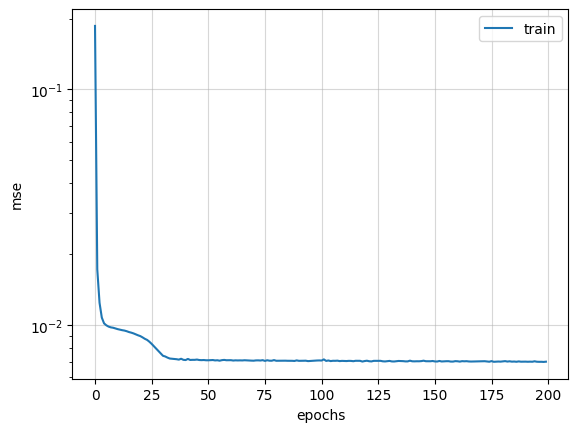

In [202]:
DNN_world_model = build_world_model()
DNN_world_model.compile(loss='mse',optimizer='adam')

inputs = inputs.reshape(inputs.shape[0] * inputs.shape[1], inputs.shape[2])
outputs = outputs.reshape(outputs.shape[0] * outputs.shape[1], outputs.shape[2])

#dnn_inputs = tf.tensor(inputs)
#dnn_outputs = tf.tensor(outputs)

hist = DNN_world_model.fit([inputs[:,:3], # states
                        np.random.randn(20000,3)*0.1, # noise applied to states
                        inputs[:,3:]], # actions
                       outputs, batch_size = 256, epochs = 200, verbose=0)

plt.plot(hist.history['loss'],label='train')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.yscale('log')
plt.grid(alpha=0.5);

### NCPS

In [215]:
from ncps.wirings import NCP
out_features = 3
in_features = 4

#wiring = AutoNCP(6, out_features)  
wiring = NCP(inter_neurons=4, command_neurons=4, motor_neurons=3,
             sensory_fanout=3, inter_fanout=3, recurrent_command_synapses=0, motor_fanin=3)

world_model = CfC(in_features, wiring, batch_first=True) # change to cfc, what could go wrong?
learn = SequenceLearner(world_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=50,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [216]:
inputs = torch.tensor(inputs, dtype=torch.float32)
outputs = torch.tensor(outputs, dtype=torch.float32)

dataloader = data.DataLoader(
    data.TensorDataset(inputs, outputs), batch_size=128, shuffle=True, num_workers=4
)

inputs.shape

/tmp/ipykernel_81950/4247279216.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/tmp/ipykernel_81950/4247279216.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.float32)


torch.Size([20000, 4])

In [217]:
trainer.fit(learn, dataloader)


  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 469    | train
---------------------------------------
384       Trainable params
85        Non-trainable params
469       Total params
0.002     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=50` reached.


## Alternatively, plug and play

In [107]:
# to be implemented

## Graphs

### Random Samples

In [206]:
t_inputs, t_outputs = get_rnd_env_samples(env, 50)

In [218]:
# NCPS Residuals
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

for i in range(200):
    c_inputs = torch.FloatTensor(t_inputs[:, i, :])
    with torch.no_grad():
        prediction = world_model(c_inputs)[0].numpy()
    
    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - t_outputs[:, i, 0])
    y_residuals.append(prediction[:, 1] - t_outputs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2]*max_angular_velocity_magnitude - t_outputs[:, i, 2]*max_angular_velocity_magnitude)

NCPS_x_res = np.stack(x_residuals).T
NCPS_y_res = np.stack(y_residuals).T
NCPS_ang_res = np.stack(ang_vel_residuals).T

In [208]:
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

for i in range(200):
    #c_inputs = torch.FloatTensor(t_inputs[:, i, :])
    prediction = np.array(DNN_world_model.predict([t_inputs[:, i,:3],
                                      np.zeros((50,3)),
                                      t_inputs[:, i,3:]])).squeeze()

    # add residuals
    #prediction = t_outputs[:, i, :] + prediction
    
    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - t_outputs[:, i, 0])
    y_residuals.append(prediction[:, 1] - t_outputs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2]*max_angular_velocity_magnitude - t_outputs[:, i, 2]*max_angular_velocity_magnitude)

DNN_x_res = np.stack(x_residuals).T
DNN_y_res = np.stack(y_residuals).T
DNN_ang_res = np.stack(ang_vel_residuals).T

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━

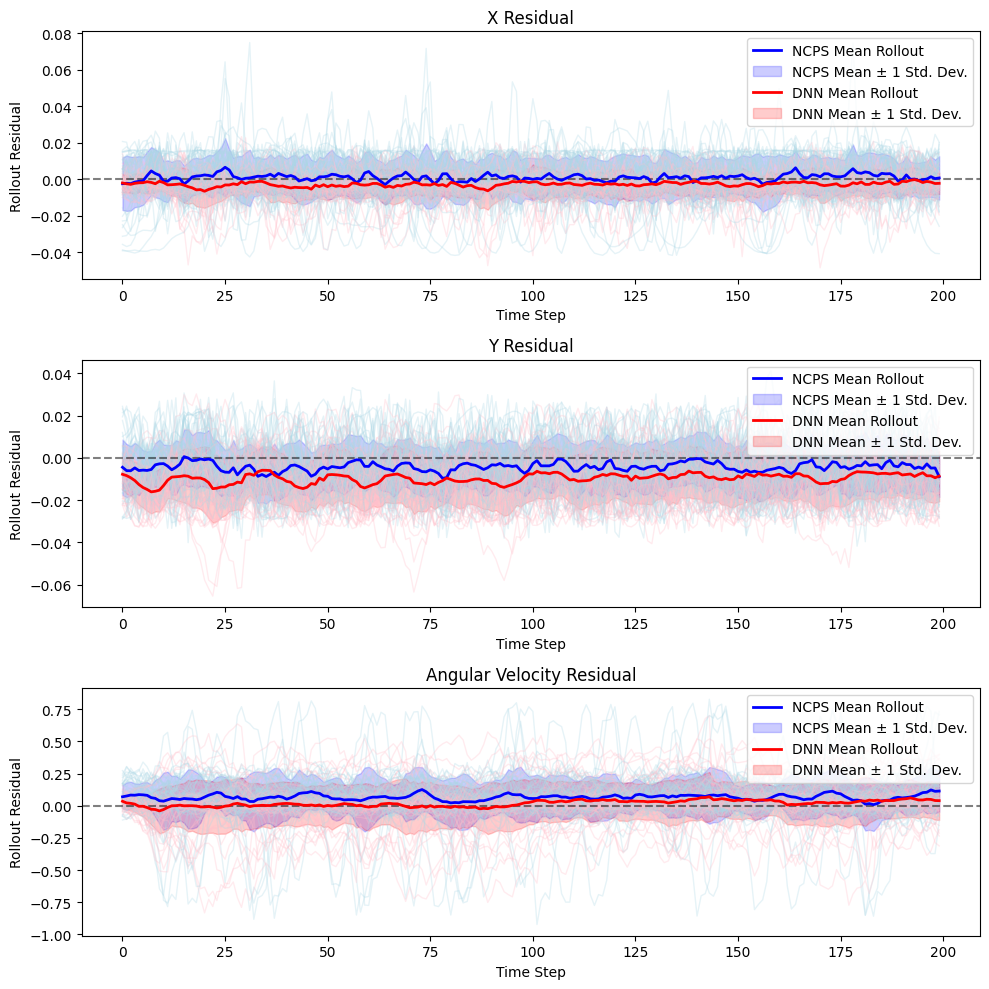

In [219]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(200)

def plot_residuals(ax, res_1, res_2, title):
    # Plot all individual rollouts
    for r in range(res_1.shape[0]):
        ax.plot(res_1[r], color='lightblue', alpha=0.3, linewidth=1)
        ax.plot(res_2[r], color='pink', alpha=0.3, linewidth=1)

    ax.axhline(0,ls='--',c='k',alpha=0.5)
    
    # Compute and plot the mean
    mean_rollout = res_1.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='NCPS Mean Rollout')

    # Compute and plot ±1 std dev
    std_rollout = res_1.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='blue', alpha=0.2, label='NCPS Mean ± 1 Std. Dev.')

    # Compute and plot the mean
    mean_rollout = res_2.mean(axis=0)
    ax.plot(mean_rollout, color='red', linewidth=2, label='DNN Mean Rollout')
    
    std_rollout = res_2.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='red', alpha=0.2, label='DNN Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], NCPS_x_res, DNN_x_res, "X Residual")

# Plot for y_res
plot_residuals(axes[1], NCPS_y_res, DNN_y_res, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], NCPS_ang_res, DNN_ang_res, "Angular Velocity Residual")

plt.tight_layout()
plt.show()


### PPO Samples

In [70]:
from baseline import train_ppo

env_name = "Pendulum-v1"
agent = train_ppo(env_name)

actionspace: 1, obs space 3
Learning... Running 200 timesteps per episode, 5 timesteps per batch for a total of 400 rollouts



Rollouts:  71%|██████████████████████████████████████████▍                 | 283/400 [04:49<01:59,  1.02s/it, loss=-259]

Achieves a rolling average loss of greater than -300, which is considered optimal. Breaking training loop...


In [71]:
t_obs = []
t_a = []
t_n_obs = []
for _ in range(50):
    
    observation, info = env.reset()
    
    terminated = False
    truncated = False

    c_obs = []
    c_a = []
    c_n_obs = []
    
    while not (terminated or truncated):
        # Get the action from the trained PPO agent
        #vect_obs = t.tensor(observation, dtype=t.float32, device='cpu')
        obs = observation
        v_obs = torch.FloatTensor(observation)

        action, log_prob = agent.get_action(v_obs)
    
        # Take a step in the environment
        observation, reward, terminated, truncated, info = env.step(action)
        
        c_obs.append(obs)
        c_a.append(action)
        c_n_obs.append(observation)
   
    # Once the episode is done, close the environment
    #env.close()

    t_obs.append(np.vstack(c_obs))
    t_a.append(np.vstack(c_a))
    t_n_obs.append(np.vstack(c_n_obs))

env.close()

t_obs = np.stack(t_obs)
t_a = np.stack(t_a)
t_n_obs = np.stack(t_n_obs)

t_obs[:, :, angular_velocity] = t_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
t_n_obs[:, :, angular_velocity] = t_n_obs[:, :, angular_velocity]/max_angular_velocity_magnitude
t_inputs = np.concatenate((t_obs, t_a), axis=2)

In [220]:
# NCPS Residuals

#t_inputs = t_obs
t_outputs = t_n_obs

x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

for i in range(200):
    c_inputs = torch.FloatTensor(t_inputs[:, i, :])
    with torch.no_grad():
        prediction = world_model(c_inputs)[0].numpy()
    
    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - t_outputs[:, i, 0])
    y_residuals.append(prediction[:, 1] - t_outputs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2]*max_angular_velocity_magnitude - t_outputs[:, i, 2]*max_angular_velocity_magnitude)

NCPS_x_res = np.stack(x_residuals).T
NCPS_y_res = np.stack(y_residuals).T
NCPS_ang_res = np.stack(ang_vel_residuals).T

In [221]:
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

for i in range(200):
    #c_inputs = torch.FloatTensor(t_inputs[:, i, :])
    prediction = np.array(DNN_world_model.predict([t_inputs[:, i,:3],
                                      np.zeros((50,3)),
                                      t_inputs[:, i,3:]])).squeeze()

    # add residuals
    #prediction = t_outputs[:, i, :] + prediction
    
    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - t_outputs[:, i, 0])
    y_residuals.append(prediction[:, 1] - t_outputs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2]*max_angular_velocity_magnitude - t_outputs[:, i, 2]*max_angular_velocity_magnitude)

DNN_x_res = np.stack(x_residuals).T
DNN_y_res = np.stack(y_residuals).T
DNN_ang_res = np.stack(ang_vel_residuals).T

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━

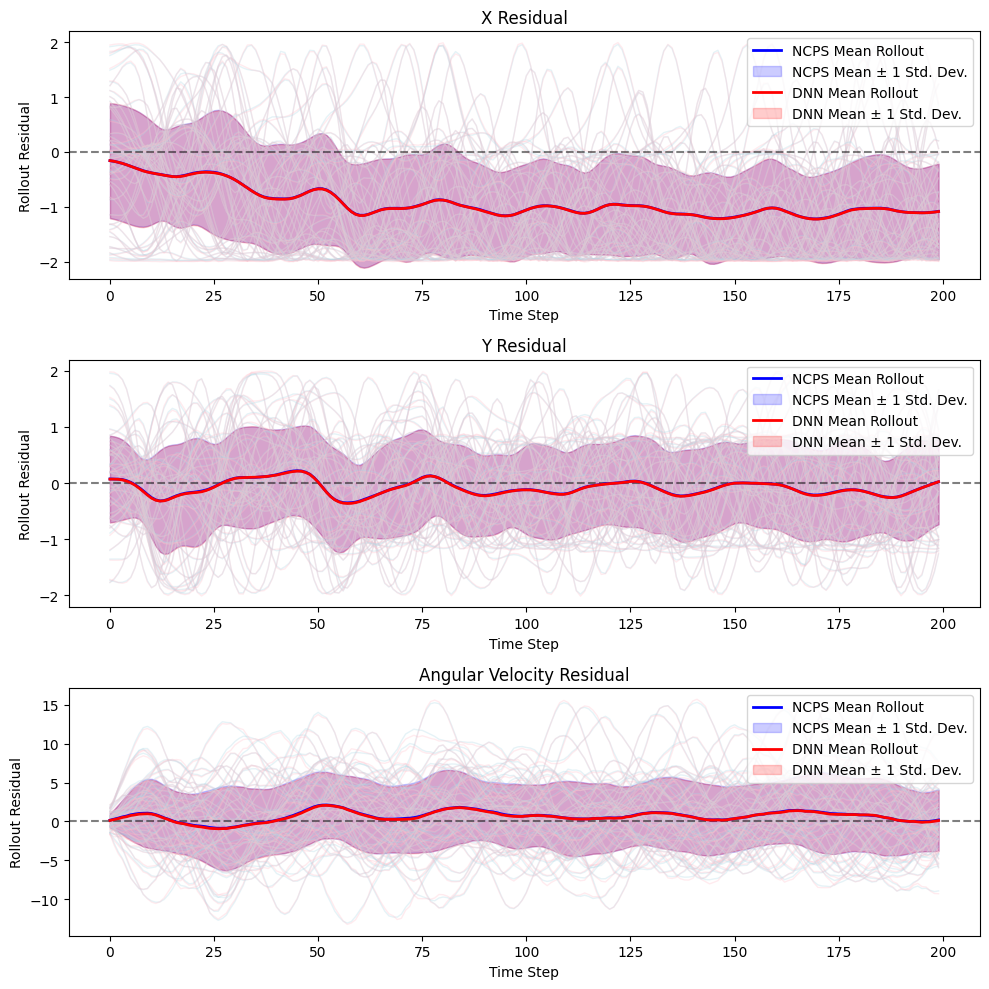

In [222]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(200)

def plot_residuals(ax, res_1, res_2, title):
    # Plot all individual rollouts
    for r in range(res_1.shape[0]):
        ax.plot(res_1[r], color='lightblue', alpha=0.3, linewidth=1)
        ax.plot(res_2[r], color='pink', alpha=0.3, linewidth=1)

    ax.axhline(0,ls='--',c='k',alpha=0.5)
    
    # Compute and plot the mean
    mean_rollout = res_1.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='NCPS Mean Rollout')

    # Compute and plot ±1 std dev
    std_rollout = res_1.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='blue', alpha=0.2, label='NCPS Mean ± 1 Std. Dev.')

    # Compute and plot the mean
    mean_rollout = res_2.mean(axis=0)
    ax.plot(mean_rollout, color='red', linewidth=2, label='DNN Mean Rollout')
    
    std_rollout = res_2.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='red', alpha=0.2, label='DNN Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], NCPS_x_res, DNN_x_res, "X Residual")

# Plot for y_res
plot_residuals(axes[1], NCPS_y_res, DNN_y_res, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], NCPS_ang_res, DNN_ang_res, "Angular Velocity Residual")

plt.tight_layout()
plt.show()


### 50 Samples Trajectories

In [223]:
inputs, outputs = get_rnd_env_samples(env, 50)

set_of_residuals = []
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

time_horizon = [inputs[:, 0, :]]

for i in range(150):
    c_inputs = torch.FloatTensor(time_horizon[-1])
    with torch.no_grad():
        prediction = world_model(c_inputs)[0].numpy()

    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - outputs[:, i, 0])
    y_residuals.append(prediction[:, 1] - outputs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2] - outputs[:, i, 2])

    #print(c_inputs)
    #print(prediction)

    res = prediction - outputs[:, i+1, :]

    #print("residuals: ", res)

    set_of_residuals.append(np.sum(np.abs(prediction - outputs[:, i, :]), axis=1))

    # add next step to time horizon

    # next step
    #print(prediction.shape)
    n_act = np.expand_dims(inputs[:, i+1, 3], axis=1)
    #print(n_act.shape)
    n = np.concatenate((prediction, n_act), axis=1)
    #print(n.shape)
    time_horizon.append(n)


x_res = np.stack(x_residuals).T
y_res = np.stack(y_residuals).T
ang_res = np.stack(ang_vel_residuals).T
set_of_res = np.stack(set_of_residuals).T
ang_res.shape

(50, 150)

In [224]:
x_residuals = []
y_residuals = []
ang_vel_residuals = []
set_of_residuals = []

set_of_predictions = []

time_horizon = [inputs[:, 0, :]]

for i in range(150):
    c_inputs = time_horizon[-1]
    zeros = np.zeros((50, 3))
    #print(c_inputs.shape)
    prediction = DNN_world_model((c_inputs[:, :3],zeros, c_inputs[:, 3]))
    prediction = np.array(prediction).squeeze()

    # save predictions
    set_of_predictions.append(prediction)

    # get residuals
    x_residuals.append(prediction[:, 0] - outputs[:, i, 0])
    y_residuals.append(prediction[:, 1] - outputs[:, i, 1])
    ang_vel_residuals.append(prediction[:, 2] - outputs[:, i, 2])
    set_of_residuals.append(np.sum(np.abs(prediction - outputs[:, i, :]), axis=1))

    # add next step to time horizon

    # next step
    #print(prediction.shape)
    n_act = np.expand_dims(inputs[:, i+1, 3], axis=1)
    #print(n_act.shape)
    n = np.concatenate((prediction, n_act), axis=1)
    #print(n.shape)
    time_horizon.append(n)

DNN_x_res = np.stack(x_residuals).T
DNN_y_res = np.stack(y_residuals).T
DNN_ang_res = np.stack(ang_vel_residuals).T
DNN_res = np.stack(set_of_residuals).T

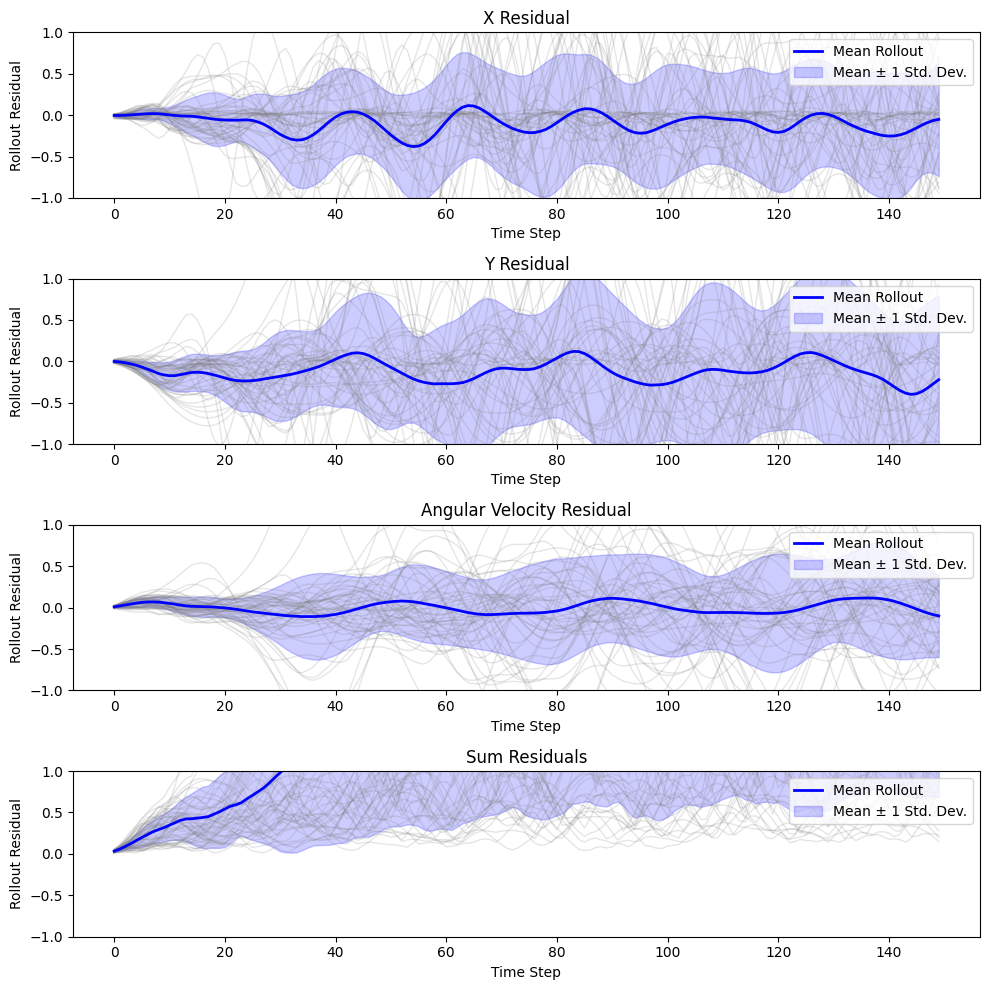

In [225]:
# Create a figure with 3 vertical subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
time_steps = np.arange(150)

# Define a function to plot the residuals on a given axis
def plot_residuals(ax, res, title):
    # Plot all individual rollouts
    for r in range(res.shape[0]):
        ax.plot(res[r], color='gray', alpha=0.2, linewidth=1)
    
    # Compute and plot the mean
    mean_rollout = res.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='Mean Rollout')
    ax.set_ylim(-1, 1)
    
    # Compute and plot ±1 std dev
    std_rollout = res.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='blue', alpha=0.2, label='Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], x_res, "X Residual")

# Plot for y_res
plot_residuals(axes[1], y_res, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], ang_res, "Angular Velocity Residual")

plot_residuals(axes[3], set_of_res, "Sum Residuals")

plt.tight_layout()
plt.show()


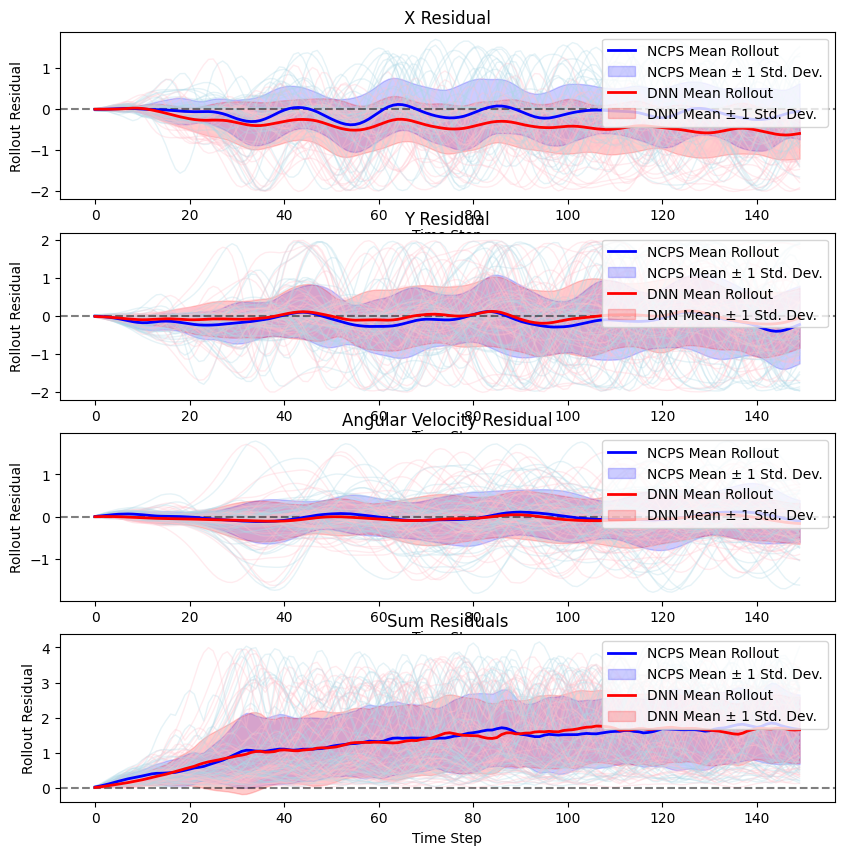

In [226]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
time_steps = np.arange(150)

def plot_residuals(ax, res_1, res_2, title):
    # Plot all individual rollouts
    for r in range(res_1.shape[0]):
        ax.plot(res_1[r], color='lightblue', alpha=0.3, linewidth=1)
        ax.plot(res_2[r], color='pink', alpha=0.3, linewidth=1)

    ax.axhline(0,ls='--',c='k',alpha=0.5)
    
    # Compute and plot the mean
    mean_rollout = res_1.mean(axis=0)
    ax.plot(mean_rollout, color='blue', linewidth=2, label='NCPS Mean Rollout')

    # Compute and plot ±1 std dev
    std_rollout = res_1.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='blue', alpha=0.2, label='NCPS Mean ± 1 Std. Dev.')

    # Compute and plot the mean
    mean_rollout = res_2.mean(axis=0)
    ax.plot(mean_rollout, color='red', linewidth=2, label='DNN Mean Rollout')
    
    std_rollout = res_2.std(axis=0)
    ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
                    color='red', alpha=0.2, label='DNN Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], x_res, DNN_x_res, "X Residual")

# Plot for y_res
plot_residuals(axes[1], y_res, DNN_y_res, "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], ang_res, DNN_ang_res, "Angular Velocity Residual")

# Plot for total res
plot_residuals(axes[3], set_of_res, DNN_res, "Sum Residuals")

